In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot_doc_level/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

In [7]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [8]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [9]:
dataset.keys()

dict_keys(['sequence', 'sentence_start_index', 'sentence_end_index', 'supporting_fact', 'segment_id', 'max_seq_len', 'max_sentences', 'document_length'])

In [10]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [11]:
dataset['document_length'][4]

[4, 2, 3, 2, 4, 22, 3, 4, 5, 3]

In [12]:
predictions_raw.shape

(73440, 5)

In [13]:
predictions_raw[:5]

array([[-10.055658 , -11.768422 , -11.992339 , -11.703031 , -11.703031 ],
       [  7.734824 ,  -6.0779786,  -6.318138 , -11.415992 , -11.415992 ],
       [-11.801379 , -12.394334 , -12.419237 , -11.978263 , -12.20426  ],
       [-11.771347 , -12.546697 , -11.700275 , -12.357806 , -12.714559 ],
       [  7.9397826, -11.4418745, -11.4418745, -11.4418745, -11.4418745]],
      dtype=float32)

In [14]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        pred_raw = predictions[start_index:start_index+len(document_lengths[i])]
        pred = []
        for j,p in enumerate(pred_raw):
            pred += p[:document_lengths[i][j]]
            pred += [0] * (document_lengths[i][j] - len(p[:document_lengths[i][j]]))
        out_list.append(pred)
        start_index += len(document_lengths[i])
    return out_list

In [15]:
predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [16]:
supporting_facts_reorganized = reorganize_predictions(dataset['supporting_fact'], dataset['document_length'])

In [17]:
for i in trange(len(predictions_reorganized)):
    assert(len(supporting_facts_reorganized[i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 877702.48it/s]


In [18]:
for i in trange(len(predictions_reorganized)):
    assert(sum(dataset['document_length'][i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 658802.48it/s]


In [19]:
def evaluate(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [20]:
evaluate(dataset['supporting_fact'], predictions_raw, 0.5, dataset['document_length'])

{'precision': 0.8479216918248844,
 'recall': 0.8014902025625099,
 'f1': 0.7990070961476389,
 'em': 0.4584694989106754}

In [21]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(dataset['supporting_fact'], predictions_raw, t, dataset['document_length'])
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:53<00:00, 12.78s/it]


In [22]:
max(metrics['f1'])

0.8029901607107698

In [23]:
max(metrics['em'])

0.4671840958605665

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [26]:
metric_df

,precision,recall,f1,em
0.10,0.748934,0.893809,0.786923,0.351171
0.15,0.773072,0.877292,0.794272,0.378813
0.20,0.789334,0.865264,0.798643,0.400327
0.25,0.803478,0.853605,0.801530,0.419390
0.30,0.815045,0.841560,0.802245,0.437364
0.35,0.824971,0.831442,0.802990,0.446623
0.40,0.833622,0.820369,0.801947,0.452478
0.45,0.841312,0.810473,0.800564,0.456019
0.50,0.847922,0.801490,0.799007,0.458469
0.55,0.852973,0.791576,0.796036,0.459831


<Figure size 432x288 with 0 Axes>

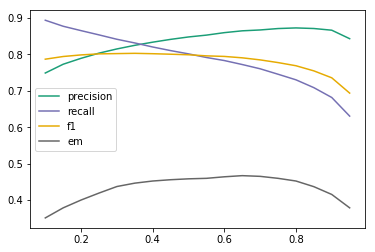

In [27]:
plt.figure(); metric_df.plot(colormap="Dark2");

In [28]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


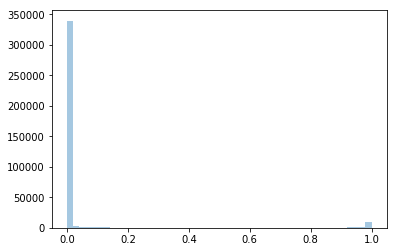

In [29]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy().flatten(),kde=False, hist=True, rug=False)

## Examining the predictions

In [30]:
threshold = 0.5

In [31]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()

In [32]:
# for individual question,paragraph pairs
wrong_prediction_indices = []
correct_prediction_indices = []
for i in range(len(dataset["supporting_fact"])):
    if( dataset["supporting_fact"][i] != pred_answer_labels[i]):
        wrong_prediction_indices.append(i)
    else:
        correct_prediction_indices.append(i)

In [33]:
len(wrong_prediction_indices)

5611

In [34]:
len(correct_prediction_indices)

67829

In [35]:
def actually_print_q_p(q_p):
    print("Question: {}".format(q_p["question"]))
    print("=============================================")
    for i, s in enumerate(q_p["sequence"]):
        print("sentence {}: {}".format(i,s))
    print("=============================================")
    print("True labels:{}".format(q_p["true_label"]))
    print("=============================================")
    print("Predicted labels:{}".format(q_p["predicted_label"]))

def print_q_p_pair(index, dataset, pred_answer_labels):
    token_ids = dataset["sequence"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    q_p = {"question":" ".join(words).split("[SEP]")[0], 
            "sequence":" ".join(words).split("[SEP]")[1].split("."),
            "true_label":true_label,
            "predicted_label": pred_answer_labels[index]
           } 
    actually_print_q_p(q_p)
    
def get_q_p(index, dataset, pred_answer_labels):
    token_ids = dataset["sequence"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    q_p = {
            "sequence":" ".join(words),
            "true_label":true_label,
            "predicted_label": pred_answer_labels[index]
           } 
    return q_p

In [36]:
get_q_p(wrong_prediction_indices[2], dataset, pred_answer_labels)

{'sequence': '[CLS] the director of the romantic comedy " big stone gap " is based in what new york city ? [SEP] big stone gap is a 2014 american drama romantic comedy film written and directed by adrian ##a tri ##gia ##ni and produced by donna gig ##lio ##tti for altar identity studios , a subsidiary of media society . based on tri ##gia ##ni \' s 2000 best - selling novel of the same name , the story is set in the actual virginia town of big stone gap circa 1970s . the film had its world premiere at the virginia film festival on november 6 , 2014 . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]